# Omics single cell bio

here I reproduce a single-cell Variational model and analysis. Sources:
* Paper: Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D.,Worth, C. L., Lindberg, E. L., … & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.
Data:
* single cells, nuclei and CD45+ enriched cells from the left and right ventricular free walls, left and right atrium, the left ventricular apex, and interventricular septum, from 14 adults.
* After processing with 10X Genomics and a generative deep variational autoencoder, the resulting dataset comprises 45,870 cells, 78,023 CD45+ enriched cells and 363,213 nuclei for 11 major cell types:"

> * atrial cardiomyocytes,
* ventricular cardiomyocytes,
* fibroblasts (FBs),
* endothelial cells (ECs),
* pericytes, smooth muscle cells (SMCs),
* immune cells (myeloid and lymphoid),
* adipocytes,
* mesothelial cells
* and neuronal cells



## Import and data Load

In [ ]:
!pip install scvi-tools

In [ ]:
!pip install scanpy

In [ ]:
!pip install --user scikit-misc

In [29]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [30]:
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.2 MB/s eta 0:00:00


In [31]:
import leidenalg

In [1]:
import os
import tempfile

import scanpy as sc
import scvi
import torch

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
#configs
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmpd8gc_4pn/hca_subsampled_20k.h5ad                                              
Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 145444.21it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [4]:
sc.pp.filter_genes(adata, min_counts=3)

# Intro

In [5]:
# normalize with log and store in .raw
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [6]:
# reduce number of features to 2k
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [43]:
adata.var.head()

,gene_ids-Harvard-Nuclei,feature_types-Harvard-Nuclei,gene_ids-Sanger-Nuclei,feature_types-Sanger-Nuclei,gene_ids-Sanger-Cells,feature_types-Sanger-Cells,gene_ids-Sanger-CD45,feature_types-Sanger-CD45,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
AL645608.8,ENSG00000272512,Gene Expression,ENSG00000272512,0,ENSG00000272512,0,ENSG00000272512,0,228.0,True,979.0,0.012231,0.015301,1.090873,1
HES4,ENSG00000188290,Gene Expression,ENSG00000188290,0,ENSG00000188290,0,ENSG00000188290,0,7493.0,True,733.0,0.401963,1.683749,1.529967,3
ISG15,ENSG00000187608,Gene Expression,ENSG00000187608,0,ENSG00000187608,0,ENSG00000187608,0,9102.0,True,311.0,0.488279,7.642043,2.148453,3
VWA1,ENSG00000179403,Gene Expression,ENSG00000179403,0,ENSG00000179403,0,ENSG00000179403,0,902.0,True,986.0,0.048388,0.119761,1.451998,2
MMP23B,ENSG00000189409,Gene Expression,ENSG00000189409,0,ENSG00000189409,0,ENSG00000189409,0,2591.0,True,737.0,0.138995,0.273973,1.467795,2


# modelling

In [8]:
# register covariates for modelling
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [9]:
model = scvi.model.SCVI(adata)

In [10]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [11]:
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [09:40<00:00,  1.44s/it, v_num=1, train_loss_step=417, train_loss_epoch=434]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:40<00:00,  1.45s/it, v_num=1, train_loss_step=417, train_loss_epoch=434]


In [12]:
# save model
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True)

In [ ]:
# load model
#model = scvi.model.SCVI.load(model_dir, adata=adata)

# check modelling

In [13]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [14]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)
latent.shape

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(18641, 10)

In [15]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,AL645608.8,HES4,ISG15,VWA1,MMP23B
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.105023,4.800139,2.754341,1.584115,3.366798
GAGTCATTCTCCGTGT-1-HCAHeart8287128,0.054799,14.990901,0.796073,2.826560,0.483369
CCTCTGATCGTGACAT-1-HCAHeart7702881,0.004491,2.241735,1.908312,0.883147,1.069286
CGCCATTCATCATCTT-1-H0035_apex,0.113384,6.491451,0.340262,0.312708,1.629646
TCGTAGAGTAGGACTG-1-H0015_septum,0.225130,7.485981,0.802853,0.425734,2.713990


In [42]:
denoised.shape

(2446, 2000)

In [41]:
denoised.iloc[:5, :]

,AL645608.8,HES4,ISG15,VWA1,MMP23B,AL034417.3,ERRFI1,SLC2A5,SPSB1,RBP7,...,LINC01678,ITGB2,COL6A1,COL6A2,S100B,MT-ND2,MT-CO2,MT-ATP6,MT-ND3,MT-ND4
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.105023,4.800139,2.754341,1.584115,3.366798,0.079272,2.550878,0.475146,2.516338,0.713686,...,0.121930,0.470807,39.205143,61.127281,0.329974,15.022941,18.324718,14.585580,12.092106,12.801222
GAGTCATTCTCCGTGT-1-HCAHeart8287128,0.054799,14.990901,0.796073,2.826560,0.483369,0.014916,4.923927,0.141771,20.149715,0.032787,...,0.147151,0.122732,27.601469,69.873222,0.001853,3.246604,13.113101,22.570705,8.654957,10.708060
CCTCTGATCGTGACAT-1-HCAHeart7702881,0.004491,2.241735,1.908312,0.883147,1.069286,0.014286,1.558484,0.074841,2.718464,0.309142,...,0.098766,0.136601,66.127167,93.646011,0.010798,18.518997,23.076324,20.178093,11.722512,16.006393
CGCCATTCATCATCTT-1-H0035_apex,0.113384,6.491451,0.340262,0.312708,1.629646,0.335967,9.976756,0.091445,5.661696,0.361362,...,0.138249,0.183986,19.973284,56.239075,0.013460,7.165529,26.049078,22.366152,11.316271,11.862574
TCGTAGAGTAGGACTG-1-H0015_septum,0.225130,7.485981,0.802853,0.425734,2.713990,0.159238,8.817315,0.319438,6.382312,0.128558,...,0.055691,0.346554,21.550262,40.823902,0.196068,7.788280,16.478182,18.718250,8.103196,10.044379


In [34]:
denoised.shape

(2446, 2000)

In [16]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

# lets add some eXplainability and visualize (+-XAI ;)

In [17]:
# PCA
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


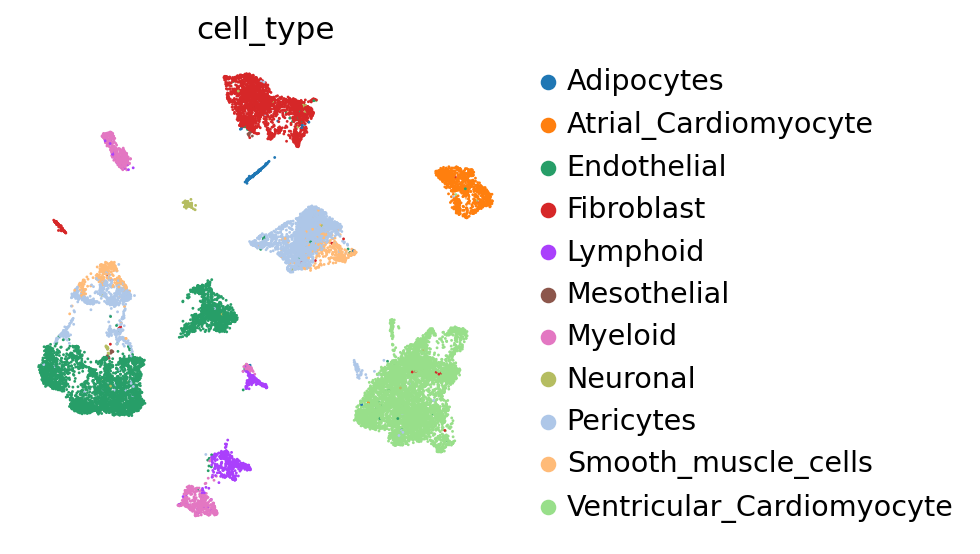

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


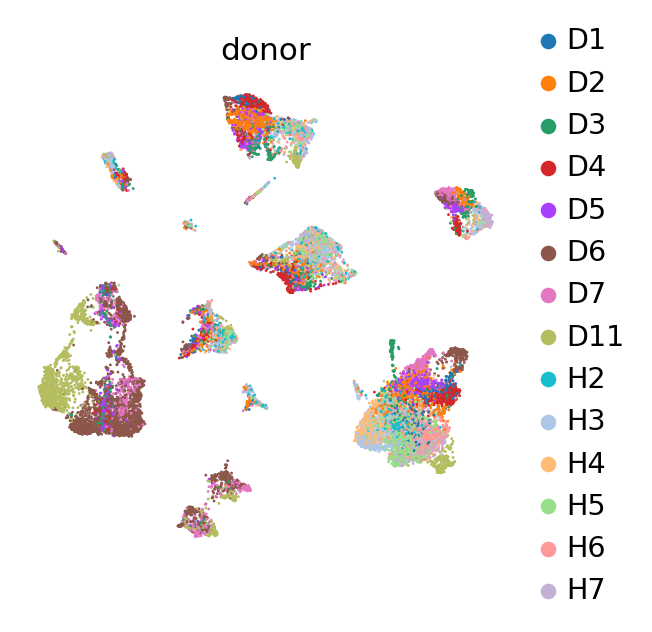

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


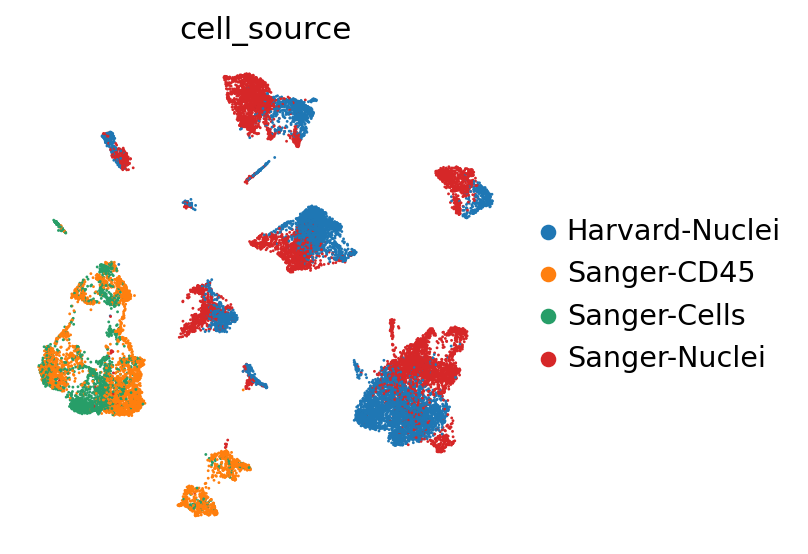

In [19]:
# UMAP plots
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["cell_source"],
    frameon=False,
)

# add batch correction and viz

In [20]:
# use latent space for umap
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


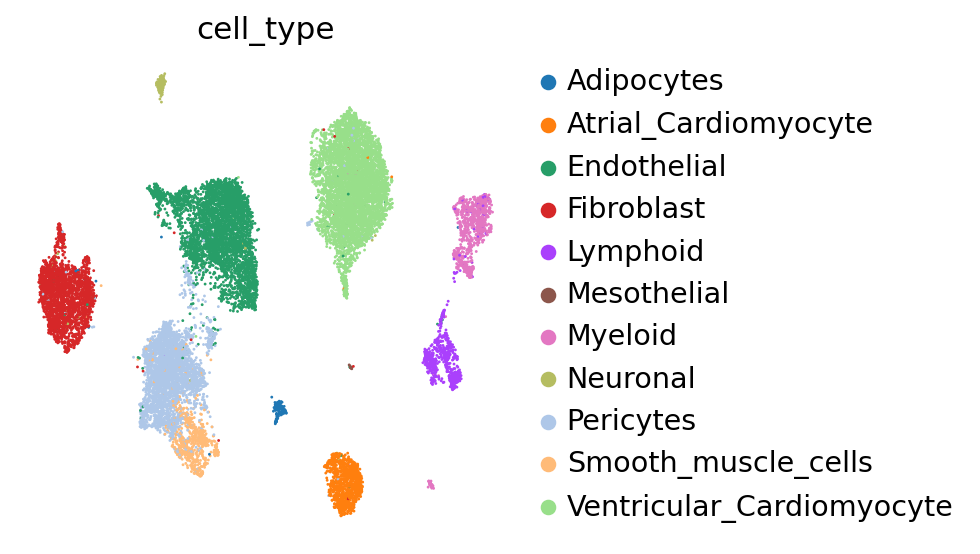

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


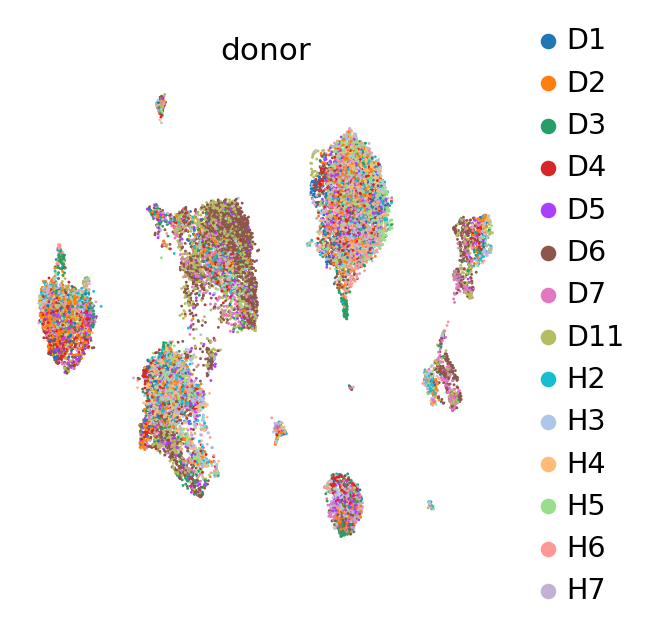

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


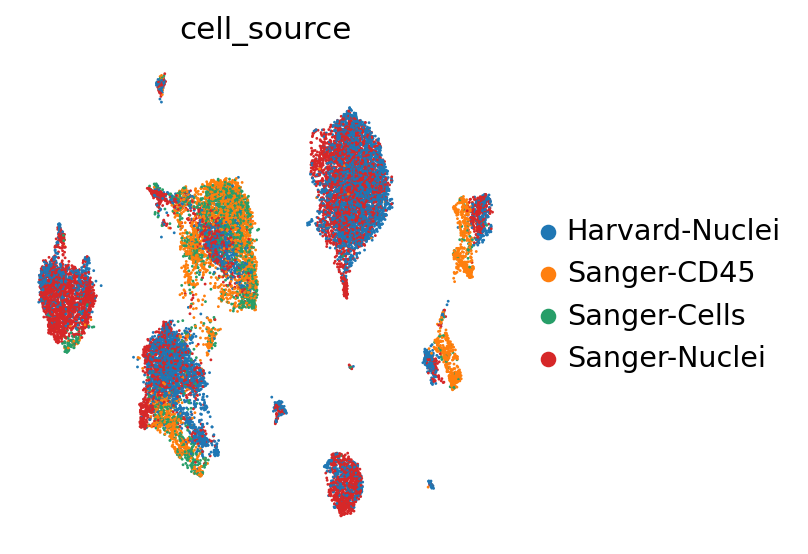

In [39]:
# umap plots
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["cell_source"],
    frameon=False,
)

# clustering of the data in the latent space

In [32]:
# based on precomputed neighbours
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


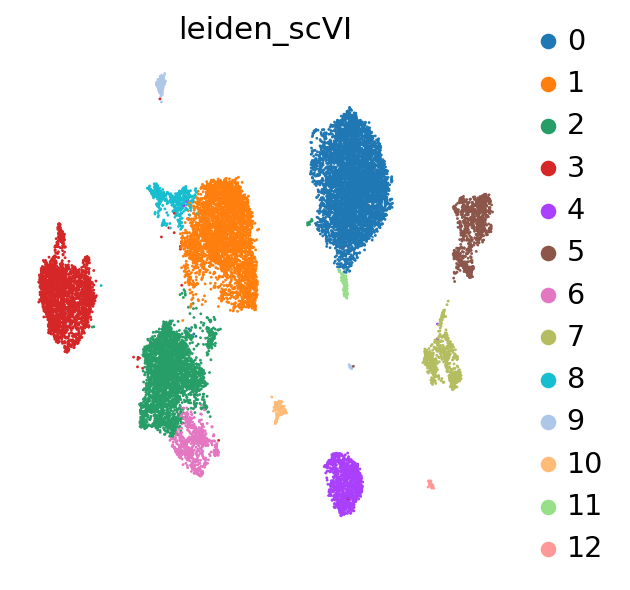

In [33]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)
